### Rough Mockup

In [23]:
import shapely
from shapely import Point, LineString, Polygon, MultiPolygon
import os
import geopandas as gpd
import pandas as pd
import math

In [2]:
a = [Point(1,1), Point(5,8), Point(7,20), Point(2,6), Point(1,1)]
a = Polygon(a)
print(a)

POLYGON ((1 1, 5 8, 7 20, 2 6, 1 1))


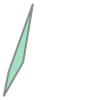

In [3]:
a

In [4]:
xx,yy = a.exterior.coords.xy
coords = a.exterior.coords.xy

In [5]:
x_coords = xx.tolist()
y_coords = yy.tolist()

In [6]:
x_coords 

[1.0, 5.0, 7.0, 2.0, 1.0]

In [7]:
y_coords

[1.0, 8.0, 20.0, 6.0, 1.0]

In [8]:
for i in range(0, len(x_coords)-1):
    coords_start = (x_coords[i], y_coords[i])
    coords_end = (x_coords[-1], y_coords[-1])
    
    if coords_start == coords_end:
        print("It is a polygon")

It is a polygon


In [9]:
from shapely import Polygon
ob = MultiPolygon([
    (
    ((0.0, 0.0), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0)),
    [((0.1,0.1), (0.1,0.2), (0.2,0.2), (0.2,0.1))]
    )
])

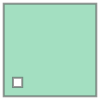

In [10]:
ob

### Idaho labels (single-polygon case)

In [43]:
idaho_df = pd.read_csv(r"Vertices_Labels\Idaho_vertices_labels.csv")
idaho_df = idaho_df.drop(columns = ["Unnamed: 0"])
idaho_df.head(2)

,Longitude,Latitude,case
0,-116.049086,49.000846,yes
1,-116.049087,49.000671,no


### Great Circle distance with a forward point

In [44]:
# calculates great circle (length) distance with a forward point
def great_circle_dist(phi1,phi2,lam1,lam2):
    import math
    phi1 = math.radians(phi1) 
    phi2 = math.radians(phi2)
    lam1 = math.radians(lam1)
    lam2 = math.radians(lam2)
    dl = abs(lam1-lam2) 
    # distance calculation
    d = math.acos((math.sin(phi1)*math.sin(phi2))+(math.cos(phi1)*math.cos(phi2)*math.cos(dl)))
    spheric_dist = d*6378.137*1000
    # spheric_dist in meters
    return spheric_dist

In [45]:
idaho_df["len_forward"] = 0.0
for i in range(len(idaho_df)-1):
    # assign data to arguments
    phi1 = idaho_df.loc[i, "Longitude"] 
    phi2 = idaho_df.loc[i+1, "Longitude"] 
    lam1 = idaho_df.loc[i, "Latitude"]
    lam2 = idaho_df.loc[i+1, "Latitude"]
    # calculate length and append to a list
    spheric_dist = great_circle_dist(phi1,phi2,lam1,lam2)
    idaho_df.loc[i, "len_forward"] = spheric_dist
    
# Assign NaN to the last row since there is no next row
idaho_df.loc[len(idaho_df) - 1, "len_forward"] = float('NaN')

In [46]:
idaho_df.head(3)

,Longitude,Latitude,case,len_forward
0,-116.049086,49.000846,yes,8.555860
1,-116.049087,49.000671,no,25.615619
2,-116.049087,49.000147,no,8.506095


In [47]:
idaho_df["len_backward"] = 0.0
for i in range(len(idaho_df)-1, 0, -1):
    # assign data to arguments
    phi1 = idaho_df.loc[i, "Longitude"] 
    phi2 = idaho_df.loc[i-1, "Longitude"] 
    lam1 = idaho_df.loc[i, "Latitude"]
    lam2 = idaho_df.loc[i-1, "Latitude"]
    # calculate length and append to a list
    spheric_dist = great_circle_dist(phi1,phi2,lam1,lam2)
    idaho_df.loc[i, "len_backward"] = spheric_dist
    
# Assign NaN to the last row since there is no next row
idaho_df.loc[0, "len_backward"] = float('NaN')

In [48]:
idaho_df.head(3)

,Longitude,Latitude,case,len_forward,len_backward
0,-116.049086,49.000846,yes,8.555860,NaN
1,-116.049087,49.000671,no,25.615619,8.555860
2,-116.049087,49.000147,no,8.506095,25.615619


In [49]:
# calculates angle formed with a forward point
def calculate_angle(x1,x2,x3,y1,y2,y3):
    # Calculate the vectors between the points
    v1 = (x1 - x2, y1 - y2)
    v2 = (x3 - x2, y3 - y2)
    
    # Calculate the dot product and the magnitudes of the vectors
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    
    # Calculate the angle in radians
    angle_rad = math.acos(dot_product / (magnitude_v1 * magnitude_v2))

    # Convert the angle from radians to degrees
    angle_deg = math.degrees(angle_rad)
    return angle_deg

In [50]:
# Create an empty column 'angle'
idaho_df["angle"] = 0.0
# Iterate over the rows of the DataFrame
for i in range(1, len(idaho_df) - 1):
    # Get the coordinates of the three points
    x1 = idaho_df.loc[i - 1, "Longitude"]
    y1 = idaho_df.loc[i - 1, "Latitude"]
    
    x2 = idaho_df.loc[i, "Longitude"]
    y2 = idaho_df.loc[i, "Latitude"]
    
    x3 = idaho_df.loc[i + 1, "Longitude"]
    y3 = idaho_df.loc[i + 1, "Latitude"]
    
    # Assign the calculated angle to the 'angle' column of the current row
    idaho_df.loc[i, 'angle'] = calculate_angle(x1,x2,x3,y1,y2,y3)

In [51]:
idaho_df.head(3)

,Longitude,Latitude,case,len_forward,len_backward,angle
0,-116.049086,49.000846,yes,8.555860,NaN,0.000000
1,-116.049087,49.000671,no,25.615619,8.555860,179.672895
2,-116.049087,49.000147,no,8.506095,25.615619,179.999908


In [52]:
idaho_df["angle"].describe()

count    35242.000000
mean       171.965616
std         12.005593
min          0.000000
25%        168.289774
50%        176.835818
75%        179.762326
max        180.000000
Name: angle, dtype: float64

In [38]:
idaho_df.fillna(0)
idaho_df.head(2)

,Longitude,Latitude,case,len_forward,len_backward,angle
0,-116.049086,49.000846,yes,8.451044,NaN,0.000000
1,-116.049087,49.000671,no,25.301809,8.451044,179.672895


In [53]:
def calculate_perpendicular_distance(x1,x2,x3,y1,y2,y3):
    # Calculate the line equation y = mx + c
    # Calculate the slope of the line
    m = (y3 - y1) / (x3 - x1)
    
    # Calculate the y-intercept of the line
    c = y1 - (m * x1)
    
    # Calculate the perpendicular distance from point i to the line
    ppdistance = abs(m * x2 - y2 + c) / math.sqrt(m**2 + 1)
    return (ppdistance*6378.137*1000)

In [54]:
# Create an empty column 'offset'
idaho_df["offset"] = 0.0
# Iterate over the rows of the DataFrame
for i in range(1, len(idaho_df) - 1):
    # Get the coordinates of the three points
    x1 = idaho_df.loc[i - 1, "Longitude"]
    y1 = idaho_df.loc[i - 1, "Latitude"]
    
    x2 = idaho_df.loc[i, "Longitude"]
    y2 = idaho_df.loc[i, "Latitude"]
    
    x3 = idaho_df.loc[i + 1, "Longitude"]
    y3 = idaho_df.loc[i + 1, "Latitude"]
    
    # Assign the calculated distance to the 'offset' column of the current row
    idaho_df.loc[i, "offset"] = calculate_perpendicular_distance(x1,x2,x3,y1,y2,y3)

idaho_df.head(3)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset
0,-116.049086,49.000846,yes,8.555860,NaN,0.000000,0.000000
1,-116.049087,49.000671,no,25.615619,8.555860,179.672895,4.777023
2,-116.049087,49.000147,no,8.506095,25.615619,179.999908,0.001334


In [56]:
def calculate_triangluar_area(x1,x2,x3,y1,y2,y3):
    # Calculate the area of the triangle using the Shoelace formula
    area = 0.5 * abs((x1 * (y2 - y3)) + (x2 * (y3 - y1)) + (x3 * (y1 - y2)))
    return (area*6378.137*1000)

In [63]:
# Create an empty column 'triangular_area'
idaho_df["triangular_area"] = 0.0
# Iterate over the rows of the DataFrame
for i in range(1, len(idaho_df) - 1):
    
    # Get the coordinates of the three points
    x1 = idaho_df.loc[i - 1, "Longitude"]
    y1 = idaho_df.loc[i - 1, "Latitude"]
    
    x2 = idaho_df.loc[i, "Longitude"]
    y2 = idaho_df.loc[i, "Latitude"]
    
    x3 = idaho_df.loc[i + 1, "Longitude"]
    y3 = idaho_df.loc[i + 1, "Latitude"]
    
    # Assign the calculated area to the 'area' column of the current row
    idaho_df.loc[i, "triangular_area"] = calculate_triangluar_area(x1,x2,x3,y1,y2,y3)

In [60]:
# calculates angle formed with a forward point
def calculate_arc_angle(x1,x2,y1,y2):
    import math
    x1 = math.radians(x1) 
    x2 = math.radians(x2)
    y1 = math.radians(y1)
    y2 = math.radians(y2)
    # angle calculation
    angle = math.atan2(y2 - y1, x2 - x1) * 180 / math.pi
    # angle in degree radians
    return angle

In [64]:
idaho_df["arc_angle"] = 0.0
for i in range(len(idaho_df)-1):
    # assign data to arguments
    x1 = idaho_df.loc[i, "Longitude"] 
    x2 = idaho_df.loc[i+1, "Longitude"] 
    y1 = idaho_df.loc[i, "Latitude"]
    y2 = idaho_df.loc[i+1, "Latitude"]
    # calculate angle formed
    idaho_df.loc[i, "arc_angle"] = calculate_arc_angle(x1,x2,y1,y2)
    
idaho_df.head(2)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,triangular_area,area,arc_angle
0,-116.049086,49.000846,yes,8.555860,NaN,0.000000,0.000000,0.00000,NaN,-90.327179
1,-116.049087,49.000671,no,25.615619,8.55586,179.672895,4.777023,0.00167,0.00167,-90.000074


In [72]:
idaho_df["ratio1"] = 0.0

for i in range(len(idaho_df)):
    if idaho_df.loc[i, "arc_angle"] != 0:
        idaho_df.loc[i, "ratio1"] =  (idaho_df.loc[i, "len_forward"] + idaho_df.loc[i, "len_backward"])/idaho_df.loc[i, "arc_angle"]
    else:
        idaho_df.loc[i, "ratio1"] = 0.0
        
idaho_df["ratio2"] = 0.0

for i in range(len(idaho_df)):
    if idaho_df.loc[i, "arc_angle"] != 0:
        idaho_df.loc[i, "ratio2"] = idaho_df.loc[i, "offset"]/idaho_df.loc[i, "arc_angle"]
    else:
        idaho_df.loc[i, "ratio2"] = 0.0
        
idaho_df.head(2)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,triangular_area,area,arc_angle,ratio1,ratio2
0,-116.049086,49.000846,yes,8.555860,NaN,0.000000,0.000000,0.00000,NaN,-90.327179,NaN,-0.000000
1,-116.049087,49.000671,no,25.615619,8.55586,179.672895,4.777023,0.00167,0.00167,-90.000074,-0.379683,-0.053078


In [85]:
idaho_df["len_backward"].fillna(idaho_df["len_backward"].median(), inplace=True)
idaho_df["triangular_area"].fillna(idaho_df["triangular_area"].median(), inplace=True)
idaho_df["ratio1"].fillna(idaho_df["ratio1"].median(), inplace=True)

In [86]:
idaho_df.head(2)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,triangular_area,area,arc_angle,ratio1,ratio2
0,-116.049086,49.000846,yes,8.555860,37.428313,0.000000,0.000000,0.00000,0.028537,-90.327179,-0.116448,-0.000000
1,-116.049087,49.000671,no,25.615619,8.555860,179.672895,4.777023,0.00167,0.001670,-90.000074,-0.379683,-0.053078


In [82]:
points_list = [(row.Longitude, row.Latitude) for row in idaho_df.itertuples()]  

In [83]:
points_gdf = gpd.GeoDataFrame(data = idaho_df, geometry = [Point(p) for p in points_list])

### Creating a random 0.4 degree buffer for each point and counting number of points within that buffer

In [84]:
points_gdf['buffer'] = points_gdf.geometry.buffer(0.4)
points_gdf.head(2)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,triangular_area,area,arc_angle,ratio1,ratio2,geometry,buffer
0,-116.049086,49.000846,yes,8.555860,37.428313,0.000000,0.000000,0.00000,0.028537,-90.327179,-0.116448,-0.000000,POINT (-116.04909 49.00085),"POLYGON ((-115.64909 49.00085, -115.65101 48.9..."
1,-116.049087,49.000671,no,25.615619,8.555860,179.672895,4.777023,0.00167,0.001670,-90.000074,-0.379683,-0.053078,POINT (-116.04909 49.00067),"POLYGON ((-115.64909 49.00067, -115.65101 48.9..."


In [87]:
sindex = points_gdf.sindex

# Iterate over the buffers and find all points that fall within each buffer
within_lists = []
for buffer in points_gdf['buffer']:
    # Find the indices of all points that intersect the buffer
    possible_matches_index = list(sindex.intersection(buffer.bounds))
    # Filter the candidate points by testing if they're actually within the buffer
    possible_matches = points_gdf.iloc[possible_matches_index]
    matches = possible_matches[possible_matches.intersects(buffer)]
    # Append the matches to the output list
    within_lists.append(list(matches.geometry))
    
# Create a new GeoDataFrame with the results
result_gdf = gpd.GeoDataFrame(geometry=[buffer for buffer in points_gdf['buffer']])
result_gdf['within'] = within_lists

In [88]:
result_gdf['point_counts'] = result_gdf['within'].apply(lambda x: len(x))
result_gdf["buffer"] = result_gdf["geometry"]
result_gdf.head(1)

,geometry,within,point_counts,buffer
0,"POLYGON ((-115.64909 49.00085, -115.65101 48.9...","[POINT (-116.0490969992152 48.82259500024346),...",310,"POLYGON ((-115.64909 49.00085, -115.65101 48.9..."


In [91]:
final_idaho_gdf = points_gdf.merge(result_gdf, on='buffer')
final_idaho_gdf.head(1)

,Longitude,Latitude,case,len_forward,len_backward,angle,offset,triangular_area,area,arc_angle,ratio1,ratio2,geometry_x,buffer,geometry_y,within,point_counts
0,-116.049086,49.000846,yes,8.55586,37.428313,0.0,0.0,0.0,0.028537,-90.327179,-0.116448,-0.0,POINT (-116.04909 49.00085),"POLYGON ((-115.64909 49.00085, -115.65101 48.9...","POLYGON ((-115.64909 49.00085, -115.65101 48.9...","[POINT (-116.0490969992152 48.82259500024346),...",310


### Sample calculation applied on Idaho

In [97]:
idaho_nn_labels_df = pd.DataFrame(final_idaho_gdf[["Longitude", "Latitude", "len_forward",
                                                   "len_backward","angle", "arc_angle",
                                                   "triangular_area","point_counts", "offset",
                                                   "ratio1", "ratio2", "case"]])
idaho_nn_labels_df.head(5)

,Longitude,Latitude,len_forward,len_backward,angle,arc_angle,triangular_area,point_counts,offset,ratio1,ratio2,case
0,-116.049086,49.000846,8.555860,37.428313,0.000000,-90.327179,0.00000,310,0.000000,-0.116448,-0.000000,yes
1,-116.049086,49.000846,8.555860,37.428313,0.000000,-90.327179,0.00000,310,0.000000,-0.116448,-0.000000,yes
2,-116.049086,49.000846,NaN,7.482380,0.000000,0.000000,0.00000,310,0.000000,0.000000,0.000000,yes
3,-116.049086,49.000846,NaN,7.482380,0.000000,0.000000,0.00000,310,0.000000,0.000000,0.000000,yes
4,-116.049087,49.000671,25.615619,8.555860,179.672895,-90.000074,0.00167,310,4.777023,-0.379683,-0.053078,no


In [98]:
idaho_nn_labels_df["len_forward"].fillna(idaho_nn_labels_df["len_forward"].median(), inplace=True)

In [99]:
idaho_nn_labels_df.head(5)

,Longitude,Latitude,len_forward,len_backward,angle,arc_angle,triangular_area,point_counts,offset,ratio1,ratio2,case
0,-116.049086,49.000846,8.555860,37.428313,0.000000,-90.327179,0.00000,310,0.000000,-0.116448,-0.000000,yes
1,-116.049086,49.000846,8.555860,37.428313,0.000000,-90.327179,0.00000,310,0.000000,-0.116448,-0.000000,yes
2,-116.049086,49.000846,37.426141,7.482380,0.000000,0.000000,0.00000,310,0.000000,0.000000,0.000000,yes
3,-116.049086,49.000846,37.426141,7.482380,0.000000,0.000000,0.00000,310,0.000000,0.000000,0.000000,yes
4,-116.049087,49.000671,25.615619,8.555860,179.672895,-90.000074,0.00167,310,4.777023,-0.379683,-0.053078,no


In [100]:
idaho_nn_labels_df.dtypes

Longitude          float64
Latitude           float64
len_forward        float64
len_backward       float64
angle              float64
arc_angle          float64
triangular_area    float64
point_counts         int64
offset             float64
ratio1             float64
ratio2             float64
case                object
dtype: object

In [101]:
idaho_nn_labels_df["point_counts"].min(), idaho_nn_labels_df["point_counts"].max()

(116, 3265)

In [104]:
idaho_nn_labels_df.to_parquet("Vertices_Labels\idaho.parq")